In [1]:
%load_ext autoreload

In [22]:
%autoreload 2

import colorcet as cc
from matplotlib import font_manager
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colormaps
from matplotlib import colors
import numpy as np
import os
import pandas as pd
import scipy
import sys
from tqdm.auto import tqdm

plt.style.use('../sci_style.py')
font_path = "/om2/user/eisenaj/miniforge3/envs/communication-transformer/fonts/arial.ttf"
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

In [9]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/dimensionality_reduction'
img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"
data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

In [10]:
figure_5_simdata = {}

# Two Dim Linear Model

In [4]:
dt = 0.00025 
# t_span = (0, 1000)
leadin = 2
response_length = 3
leadout = 2
gap = 0
t_span = (0, 7)
t_eval = np.arange(t_span[0], t_span[1], dt)
T = len(t_eval)
N = 2

noise_scale = 0.005
init_scale = noise_scale
# noise_scale = 0

# mu = -0.06
# INPUT 1
I = np.zeros((len(t_eval), 2))
I_length1 = 0.5
time_I = np.arange(0, I_length1, dt)
input_scale1 = 0.6
rand_uvec = np.random.randn(2)
rand_uvec /= np.linalg.norm(rand_uvec)
amp = rand_uvec*input_scale1
freq = 0
sin_waves = np.expand_dims(np.cos(freq*time_I*2*np.pi), -1)*np.expand_dims(amp, 0)
I[int(leadin/dt):int(leadin/dt) + int(I_length1/dt)] = sin_waves

# INPUT 2
I_length2 = 0.15
time_I = np.arange(0, I_length2, dt)
input_scale2 = 1
# rand_uvec = np.random.randn(2)
# rand_uvec /= np.linalg.norm(rand_uvec)
amp = rand_uvec*input_scale2
freq = 0
sin_waves = np.expand_dims(np.cos(freq*time_I*2*np.pi), -1)*np.expand_dims(amp, 0)
I[int((leadin + 1)/dt):int((leadin + 1)/dt) + int(I_length2/dt)] = sin_waves

def linear(t, x, A, u):
    return (A @ x) + u[t]
def g_dW(x, scale):
    return scale

# a = -6 # 1/s
sims = {}
a_vals = [-6, -1]
for a in a_vals:
    b = 2*np.pi  # rad/s
    # M = np.random.randn(2, 2)
    uvecs = np.random.randn(2, 2)
    uvecs = np.linalg.qr(uvecs)[0]
    uvecs /= np.linalg.norm(uvecs, axis=0)
    M = uvecs
    A = M @ np.array([[a, -b], [b, a]]) @ np.linalg.inv(M)

    NUM_SIMS = 1
    # Initialize the x array
    x = np.zeros((NUM_SIMS, T, N))
    for num_sim in tqdm(range(NUM_SIMS)):

        x0 = np.random.randn(2)*init_scale

        dW = np.sqrt(dt) * np.random.randn(T,N)
        x[num_sim, 0] = x0

        # Simulate the stochastic differential equation
        for t in range(1, T):
            x[num_sim, t] = x[num_sim, t-1] + np.array(linear(t, x[num_sim, t-1], A, I)) * dt + g_dW(x[num_sim, t-1], scale=noise_scale) * dW[t]

    sims[a] = x

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
i = 1
while os.path.exists(os.path.join(save_dir, f"linear2dim_v{i}.pkl")):
    i += 1

In [6]:

params = {
    'a_vals': a_vals,
    'I_lengths': [I_length1, I_length2],
    'input_scales': [input_scale1, input_scale2],
    'noise_scale': noise_scale,
}
i = 1
while os.path.exists(os.path.join(save_dir, f"linear2dim_v{i}.pkl")):
    i += 1
pd.to_pickle({'sims': sims, 'params': params}, os.path.join(save_dir, f"linear2dim_v{i}.pkl"))

In [7]:
d = pd.read_pickle(os.path.join(save_dir, 'linear2dim_v6.pkl'))
# d = pd.read_pickle(os.path.join(save_dir, 'linear2dim_v5.pkl'))
sims = d['sims']
params = d['params']
a_vals = params['a_vals']
I_lengths = params['I_lengths']
input_scales = params['input_scales']
noise_scale = params['noise_scale']

In [11]:
figure_5_simdata['2d_sim'] = d

3.0050347222222222 2.0771711111111117


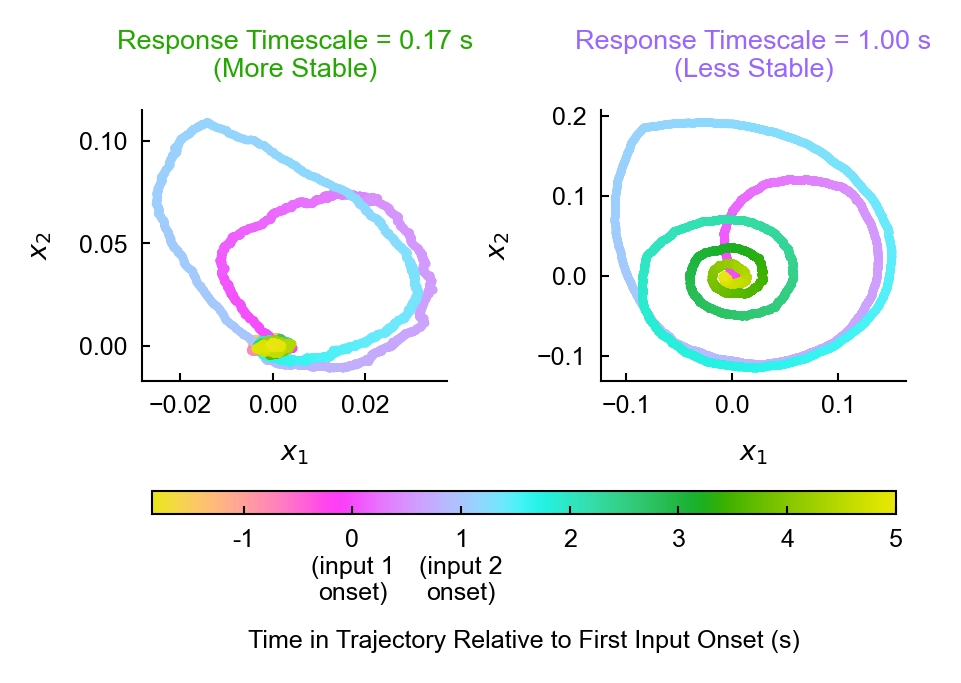

In [12]:
gap = 620
cmap_name = 'cet_CET_C7'

markersize = 1

fig, axs = plt.subplots(1, 2, figsize=(3.1, 1.937))
for i, a in enumerate(a_vals):
    x = sims[a][:, gap:]
    n_timepts = x.shape[1]
    ax = axs[i]
    color_list = colormaps.get_cmap(cmap_name)(np.linspace(0, 1, x.shape[1]))
    ax.scatter(x.mean(axis=0)[:, 0], x.mean(axis=0)[:, 1], c=color_list, s=markersize)
    sm = plt.cm.ScalarMappable(cmap=colormaps.get_cmap(cmap_name), norm=plt.Normalize(vmin=0, vmax=1))

    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    color = '#24a800' if i == 0 else '#9966ff'
    ax.set_title(f"Response Timescale = {1/np.abs(a):.2f} s\n({'More Stable' if i == 0 else 'Less Stable'})", c=color, fontsize=6.5)


cbar_tick_labels = np.arange(10)
cbar_tick_labels = cbar_tick_labels[cbar_tick_labels <= (leadin + response_length + leadout)]
cbar_tick_labels = cbar_tick_labels[cbar_tick_labels >= gap*dt]
cbar_ticks = cbar_tick_labels/dt - gap
cbar_tick_labels -= leadin
start_ind = np.where(cbar_tick_labels == 0)[0][0]
cbar_tick_labels = list(cbar_tick_labels)
# cbar_tick_labels[]
cbar_tick_labels[start_ind] = f"{cbar_tick_labels[start_ind]:d}\n(input 1\nonset)"
cbar_tick_labels[start_ind + 1] = f"{cbar_tick_labels[start_ind + 1]:d}\n(input 2\nonset)"

plt.tight_layout()

# vpad = 0.2
# hpad = 0.2
vpad = 0.35
plt.subplots_adjust(bottom=vpad)

cbar_ax = fig.add_axes([0.160, 0.12, 0.8, 0.04])
tick_labels = np.arange(0, int(n_timepts*dt), 1)
cbar = fig.colorbar(sm, orientation='horizontal', ticks=cbar_ticks/n_timepts, cax=cbar_ax)
cbar.set_ticklabels(cbar_tick_labels)
cbar.set_label('Time in Trajectory Relative to First Input Onset (s)', fontsize=6)


bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

plt.savefig(os.path.join(img_save_dir, 'main', 'simulated.pdf'), transparent=True, bbox_inches='tight')

plt.show()


# One dim linear model

In [13]:
def response_1D_filter(t,a, freq=1):
  return (a*np.sin(t*2*np.pi*freq) - np.cos(t*2*np.pi*freq))*(1/(a**2+1))

In [14]:
ts = np.linspace(0,10,1000)
ts2 = np.linspace(0, 1, 1000)

In [15]:
# import matplotlib.cm as cm
# from matplotlib.colors import Normalize

# cmap = cm.jet
# norm = Normalize(vmin=1e-3, vmax=10)

# # ts = np.linspace(0,10,1000)
# ts = np.linspace(0, 2, 1000)

# fig = plt.figure(figsize=(8, 5))

# for lam in np.arange(0,5,0.5):
#   if lam == 0:
#     lam += 1e-3
#   ys_1 = response_1D_filter(t = ts,a = lam)
#   plt.plot(ts,ys_1,color = cmap(lam/5),label = f'$\lambda = {lam}$')

# ax = plt.gca()
# ax.spines[['right', 'top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# plt.xlabel('Time (s)')
# plt.ylabel('Response')
# plt.title('Response of Linear Filter \n $\dot{x} = -\lambda x + sin(t)$')

# sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('jet'), norm=plt.Normalize(vmin=0, vmax=4.5))
# cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.8])
# cbar = fig.colorbar(sm, ticks=[0, 1, 2, 3, 4], cax=cbar_ax)
# # cbar.ax.set_yticklabels())
# cbar.set_label(fr'Stabilizing Parameter ($\lambda$)')

# # plt.legend()
# plt.show()

In [16]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/linear'
os.makedirs(save_dir, exist_ok=True)

In [17]:
# sde_run_dict = {'x_1': x_1, 'x_2': x_2}
# # lam1, lam2 = 10, 1e-2
# pd.to_pickle(sde_run_dict, os.path.join(save_dir, f"{lam_1}_{lam_2}.pkl"))

lam_1, lam_2 = 10, 1e-2
sde_run_dict = pd.read_pickle(os.path.join(save_dir, f"{lam_1}_{lam_2}.pkl"))
x_1, x_2 = sde_run_dict['x_1'], sde_run_dict['x_2']

In [20]:
figure_5_simdata['1d_sim'] = sde_run_dict

In [18]:
# # # Define the parameters
# # # N = int(1e5)
# # N = int(1e3)
# # T = 3.0
# # dt = T / N
# # x0 = 0.0
# # ts = np.linspace(0,T,N)
# # #lam = 1

# # # Define the Weiner process
# # dW = np.sqrt(dt) * np.random.randn(N)

# # def do_one_sde_run(lam,ts):
# #   # Define the function f(x)
# #   def f(x,lam):
# #       return -lam * x

# #   # Define the function g(x)
# #   def g(x):
# #       return 0.05

# #   # Initialize the x array
# #   x = np.zeros(N)
# #   x[0] = x0

# #   sine_on = 0

# #   # Simulate the stochastic differential equation
# #   for i,time in enumerate(ts):

# #       if (time >= 1 and time < 1.5):
# #         sine_on = -1
# #         freq = 2
# #       elif (time >= 2 and time < 2.5):
# #         sine_on = -1
# #         freq = 2
# #       else:
# #         sine_on = 0
# #         freq = 1

# #       x[i] = x[i-1] + (f(x[i-1],lam) + + sine_on*np.sin(2*np.pi*freq*time)) * dt + g(x[i-1]) * dW[i]

# #   return x

# # #try two different lambdas
# # lam_1, lam_2 = 10, 1e-2
# # x_1 = do_one_sde_run(lam = lam_1,ts = ts)
# # x_2 = do_one_sde_run(lam = lam_2,ts = ts)

# plt.figure(figsize=(8, 5))

# # Plot the results
# plt.plot(ts - 1, x_1, label = f'$\lambda = {lam_1}$')
# plt.plot(ts - 1, x_2, label = f'$\lambda = {lam_2}$', c='orange')

# ax = plt.gca()
# ax.spines[['right', 'top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

# ax.axvline(0, c='k', lw=2, linestyle='--', label='input 1', alpha=0.75)
# ax.axvline(1, c='midnightblue', lw=2, linestyle='--', label='input 2', alpha=0.75)


# plt.legend(fontsize=18)
# plt.xlabel('Time Relative to Input Onset (s)')
# plt.ylabel('Response')
# plt.title('Noisy Linear Filter with Two Inputs\n$\dot{x} = -\lambda x + u(t)$')

# plt.show()

4.417096118728608 1.62


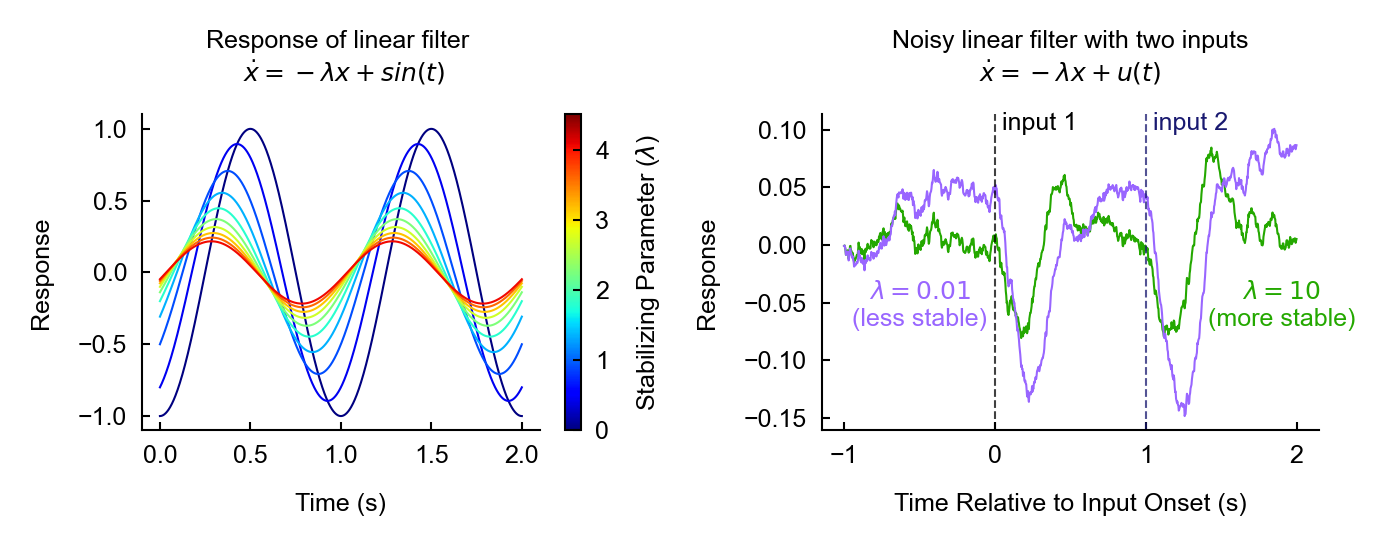

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(4.6, 1.8))

cmap = cm.jet
norm = colors.Normalize(vmin=1e-3, vmax=10)

titlesize=6
labelsize = 6

# ts = np.linspace(0,10,1000)
ts = np.linspace(0, 2, 1000)

for lam in np.arange(0,5,0.5):
  if lam == 0:
    lam += 1e-3
  ys_1 = response_1D_filter(t = ts,a = lam)
  axs[0].plot(ts,ys_1,color = cmap(lam/5),label = f'$\lambda = {lam}$')

# ax = plt.gca()
# ax.spines[['right', 'top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

axs[0].set_xlabel('Time (s)', fontsize=labelsize)
axs[0].set_ylabel('Response', fontsize=labelsize)
axs[0].set_title('Response of linear filter \n $\dot{x} = -\lambda x + sin(t)$', fontsize=titlesize)

sm = plt.cm.ScalarMappable(cmap=colormaps.get_cmap('jet'), norm=plt.Normalize(vmin=0, vmax=4.5))
cbar = fig.colorbar(sm, ticks=[0, 1, 2, 3, 4], ax=axs[0])
# cbar.ax.set_yticklabels())
cbar.set_label(fr'Stabilizing Parameter ($\lambda$)', fontsize=labelsize)

plt.subplot(1, 2, 2)
N = int(1e3)
T = 3.0
dt = T / N
x0 = 0.0
ts = np.linspace(0,T,N)

# Plot the results
# plt.plot(ts - 1, x_1, label = f'$\lambda = {lam_1}$\n(more stable)', c='#f7931e')
axs[1].plot(ts - 1, x_1, label = f'$\lambda = {lam_1}$\n(more stable)', c='#24a800')

axs[1].plot(ts - 1, x_2, label = f'$\lambda = {lam_2}$\n(less stable)', c='#9966ff')

# ax = plt.gca()
# ax.spines[['right', 'top']].set_visible(False)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

axs[1].axvline(0, c='k',linestyle='--', label='input 1', alpha=0.75)
axs[1].axvline(1, c='midnightblue',linestyle='--', label='input 2', alpha=0.75)


# axs[1].legend(loc='center', bbox_to_anchor=(0.5, -0.1), ncol=4)
axs[1].text(1.9, -0.07, f'$\lambda = {lam_1}$\n(more stable)', c='#24a800', ha='center')
axs[1].text(-0.5, -0.07, f'$\lambda = {lam_2}$\n(less stable)', c='#9966ff', ha='center')
axs[1].text(0.05, 0.1, 'input 1', c='k')
axs[1].text(1.05, 0.1, 'input 2', c='midnightblue')
axs[1].set_xlabel('Time Relative to Input Onset (s)', fontsize=labelsize)
axs[1].set_ylabel('Response', fontsize=labelsize)
axs[1].set_title('Noisy linear filter with two inputs\n$\dot{x} = -\lambda x + u(t)$', fontsize=titlesize)
plt.tight_layout()

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

plt.savefig(os.path.join(img_save_dir, "main", "linear1d.pdf"), bbox_inches='tight', transparent=True, dpi=300)

plt.show()

In [25]:
scipy.io.savemat(os.path.join(data_save_dir, 'figure5_6_simdata.mat'), figure_5_simdata)

# Spring

In [13]:
def spring(t, x, M=10, k=1, R=10, I=0):
    if isinstance(I, np.ndarray):
        I = I[int(t/dt)]
    return [x[1], (-k*x[0] - R*x[1] + I)/M]

In [14]:
from scipy.integrate import solve_ivp

1.823467777777778 1.312232777777778


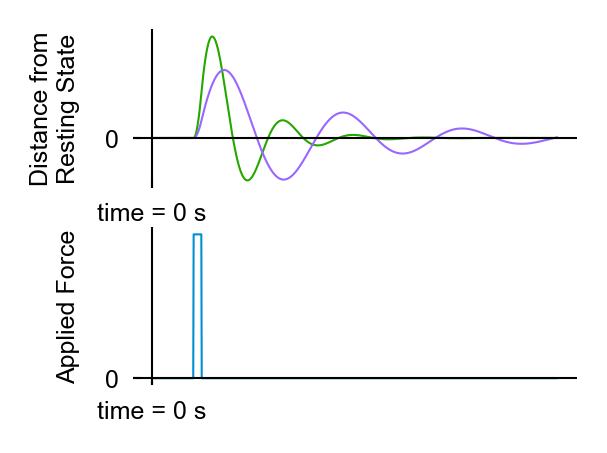

In [29]:
t_span = [0, 20]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
I = np.zeros(int(len(t_eval)*1.5))
I[100:120] = 10

sol = solve_ivp(lambda t, x: spring(t, x, k=70, M=5, I=I), y0=[0, 0], t_span=t_span, t_eval=t_eval)
x = sol.y.T
shift = 4
length = 1000

fig, axs = plt.subplots(2, 1, figsize=(1.9096, 1.5415))
plt.subplots_adjust(hspace=0.25)
ax = axs[0]
# ax.plot(np.arange(length) + shift, x[:length, 0], c='#f7931e', lw=6, alpha=1)
ax.plot(np.arange(length) + shift, x[:length, 0], c='#24a800', alpha=1)
sol = solve_ivp(lambda t, x: spring(t, x, k=70, M=15, I=I), y0=[0, 0], t_span=t_span, t_eval=t_eval)
x = sol.y.T
ax.plot(np.arange(length) + shift, x[:length, 0], c='#9966ff', alpha=1)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([0], ['time = 0 s'])
ax.set_yticks([0], [0])
ax.axhline(0, c='k')
ax.axvline(0, c='k')

ax.set_ylabel('Distance from\nResting State', fontsize=6)

ax = axs[1]
ax.plot(np.arange(length) + shift, I[:length])

ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([0], ['time = 0 s'])
ax.set_yticks([0])
ax.axhline(0, c='k')
ax.axvline(0, c='k')

ax.set_ylabel('Applied Force', fontsize=6)

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

plt.savefig(os.path.join(img_save_dir, "main", "spring.pdf"), bbox_inches='tight', transparent=True, dpi=300)
plt.show()